In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

C:\Users\Tonijua\anaconda3\envs\mfe-preprogram\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///D://UCB//Pre-MFE 2022//Python//UCB-MFE-python-preprogram//Lectures//Lecture 4//data//data.db'

In [3]:
# Parameters
from_date = "2021-11-29 00:00:00"
to_date = "2021-12-11 00:00:00"
token = "CRV"
connection_string = "sqlite:///D://UCB//Pre-MFE 2022//Python//UCB-MFE-python-preprogram//Lectures//Lecture 4//data//data.db"


In [4]:
# get data from database
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)

prices['ts'] = pd.to_datetime(prices['ts'])
prices.set_index('ts', inplace=True)
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-29 00:00:00,4.7441,4.9019,4.7360,4.8862,351765.15,1.705798e+06,CRV,ETH
2021-11-29 01:00:00,4.8830,5.0237,4.8456,4.9916,319432.21,1.583582e+06,CRV,ETH
2021-11-29 02:00:00,4.9916,5.0419,4.9066,4.9087,366517.02,1.819949e+06,CRV,ETH
2021-11-29 03:00:00,4.9078,4.9431,4.8661,4.8928,313299.76,1.535474e+06,CRV,ETH
2021-11-29 04:00:00,4.8884,4.9077,4.7795,4.7959,184738.04,8.929033e+05,CRV,ETH


In [5]:
# calculate the hourly return by timestamp
prices["hourly_return"] = prices.close / prices.close.shift(1) - 1
prices.head()

,open,high,low,close,volume,volumeUSD,token,chain,hourly_return
ts,,,,,,,,,
2021-11-29 00:00:00,4.7441,4.9019,4.7360,4.8862,351765.15,1.705798e+06,CRV,ETH,NaN
2021-11-29 01:00:00,4.8830,5.0237,4.8456,4.9916,319432.21,1.583582e+06,CRV,ETH,0.021571
2021-11-29 02:00:00,4.9916,5.0419,4.9066,4.9087,366517.02,1.819949e+06,CRV,ETH,-0.016608
2021-11-29 03:00:00,4.9078,4.9431,4.8661,4.8928,313299.76,1.535474e+06,CRV,ETH,-0.003239
2021-11-29 04:00:00,4.8884,4.9077,4.7795,4.7959,184738.04,8.929033e+05,CRV,ETH,-0.019805


In [6]:
# calculate the hourly volatility

def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [7]:
prices['volatility'] = vol_ohlc(prices)
prices.head(20)

,open,high,low,close,volume,volumeUSD,token,chain,hourly_return,volatility
ts,,,,,,,,,,
2021-11-29 00:00:00,4.7441,4.9019,4.7360,4.8862,351765.15,1.705798e+06,CRV,ETH,NaN,NaN
2021-11-29 01:00:00,4.8830,5.0237,4.8456,4.9916,319432.21,1.583582e+06,CRV,ETH,0.021571,NaN
2021-11-29 02:00:00,4.9916,5.0419,4.9066,4.9087,366517.02,1.819949e+06,CRV,ETH,-0.016608,NaN
2021-11-29 03:00:00,4.9078,4.9431,4.8661,4.8928,313299.76,1.535474e+06,CRV,ETH,-0.003239,NaN
2021-11-29 04:00:00,4.8884,4.9077,4.7795,4.7959,184738.04,8.929033e+05,CRV,ETH,-0.019805,NaN
2021-11-29 05:00:00,4.7986,4.9008,4.7953,4.8352,246952.52,1.193081e+06,CRV,ETH,0.008194,NaN
2021-11-29 06:00:00,4.8390,4.8505,4.7905,4.8078,83697.23,4.026653e+05,CRV,ETH,-0.005667,NaN
2021-11-29 07:00:00,4.8152,4.8600,4.8114,4.8554,49267.06,2.383074e+05,CRV,ETH,0.009901,NaN
2021-11-29 08:00:00,4.8566,4.8774,4.8367,4.8588,45840.86,2.226650e+05,CRV,ETH,0.000700,NaN


In [8]:
# calculate maximum drawdown up to that hour for each hour
prices.reset_index(inplace=True)
for index, row in prices.iterrows():
    # first we calculate the drawdown up to each hour
    prices.loc[index, 'hourly_drawdown'] = (prices.loc[index, 'low'] - prices.loc[0:index, 'high'].max())/prices.loc[0:index, 'high'].max()
    # then we select the maximum drawdown up to that hour
    prices.loc[index, 'max_drawdown'] = prices.loc[0:index, 'hourly_drawdown'].min()
prices.set_index('ts', inplace=True) 
prices.head()


,open,high,low,close,volume,volumeUSD,token,chain,hourly_return,volatility,hourly_drawdown,max_drawdown
ts,,,,,,,,,,,,
2021-11-29 00:00:00,4.7441,4.9019,4.7360,4.8862,351765.15,1.705798e+06,CRV,ETH,NaN,NaN,-0.033844,-0.033844
2021-11-29 01:00:00,4.8830,5.0237,4.8456,4.9916,319432.21,1.583582e+06,CRV,ETH,0.021571,NaN,-0.035452,-0.035452
2021-11-29 02:00:00,4.9916,5.0419,4.9066,4.9087,366517.02,1.819949e+06,CRV,ETH,-0.016608,NaN,-0.026835,-0.035452
2021-11-29 03:00:00,4.9078,4.9431,4.8661,4.8928,313299.76,1.535474e+06,CRV,ETH,-0.003239,NaN,-0.034868,-0.035452
2021-11-29 04:00:00,4.8884,4.9077,4.7795,4.7959,184738.04,8.929033e+05,CRV,ETH,-0.019805,NaN,-0.052044,-0.052044


In [9]:
# then plot in a 2x2 grid:
# hourly return
# hourly vol
# maximum drawdown
# close prices
# color each day on the graph

def series_plot(data, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)



In [10]:
%%capture
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

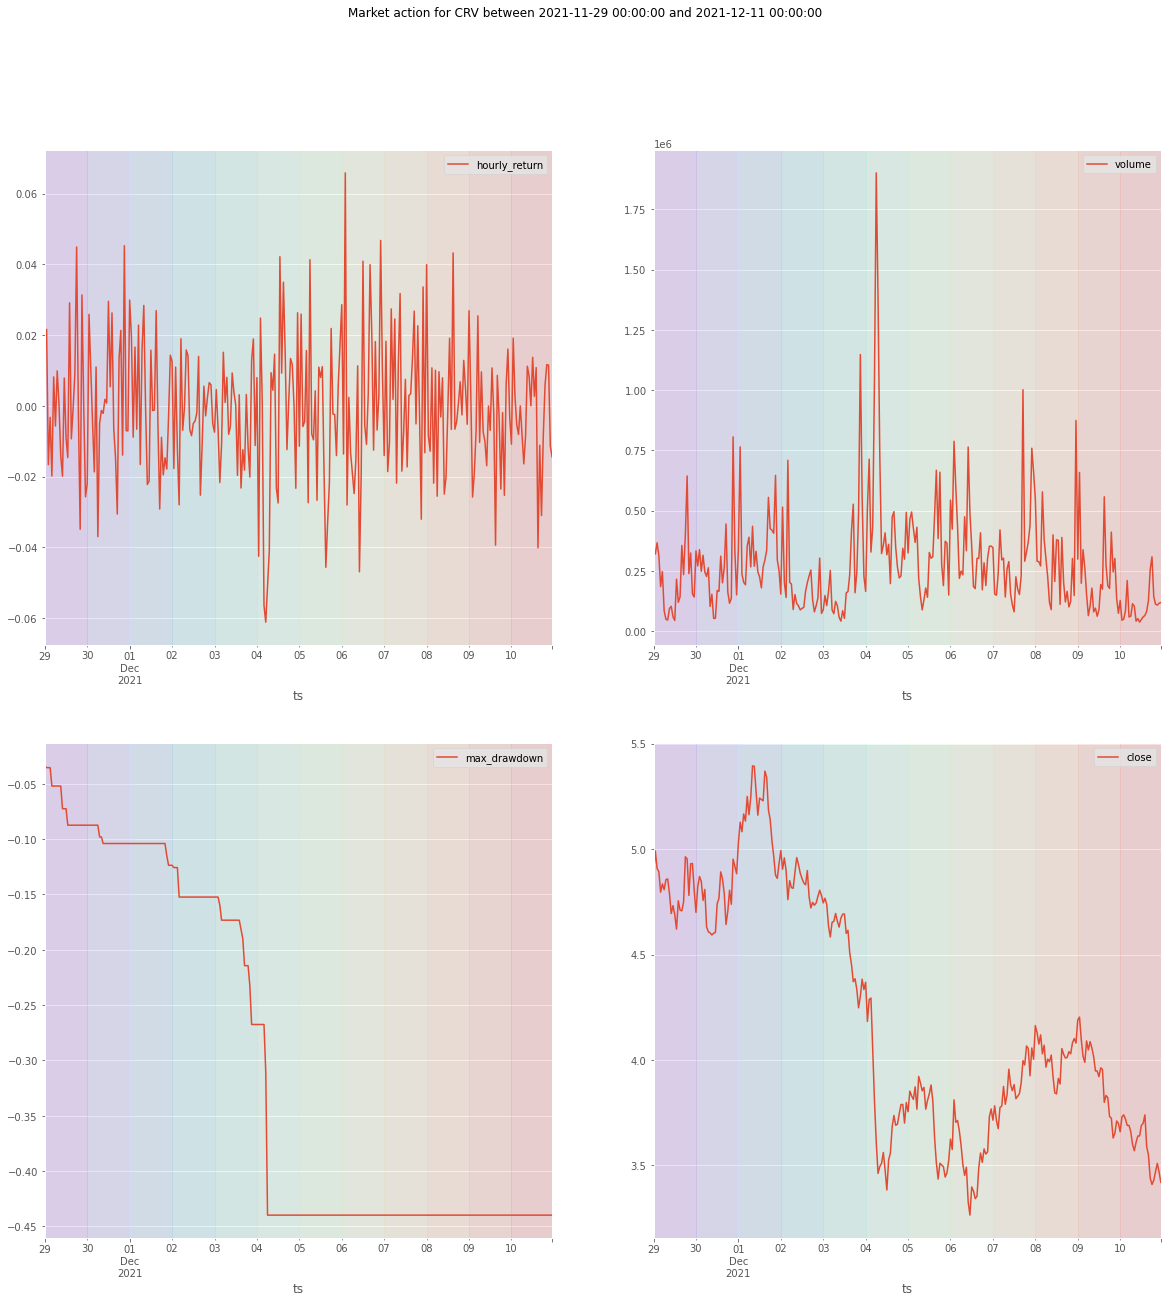

In [11]:
series_plot(prices[['hourly_return']], ax=ax[0, 0])
series_plot(prices[['volume']], ax=ax[0, 1])
series_plot(prices[['max_drawdown']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

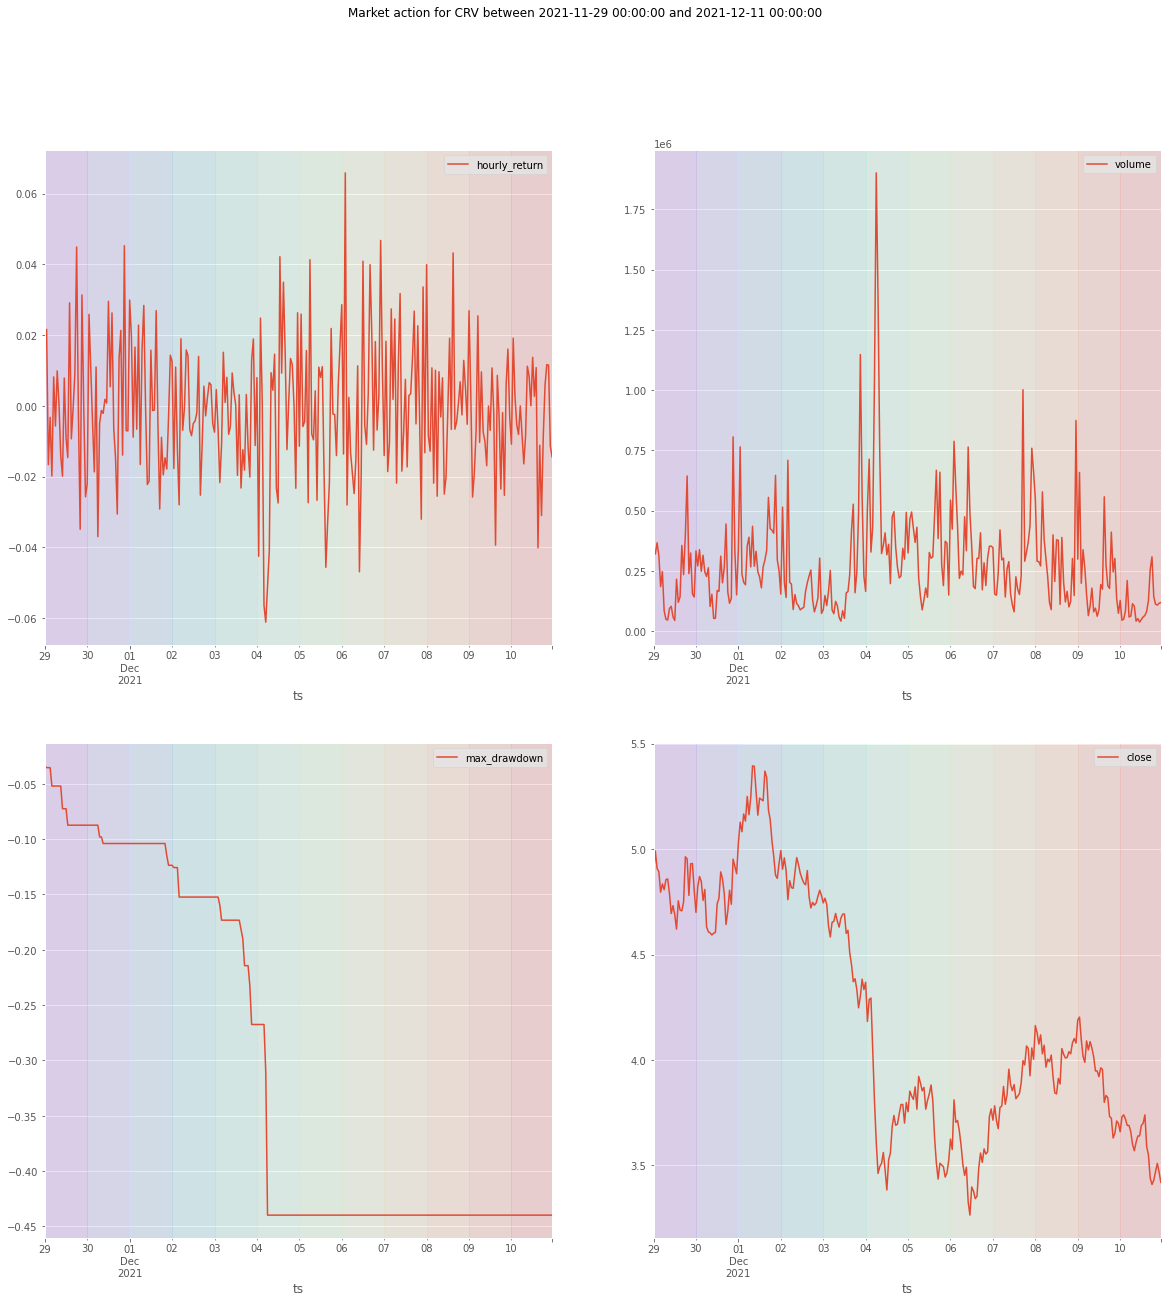

In [12]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)